In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from graphviz import Digraph

In [22]:
class Value:
  
  # To initialize an object with a value
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
        # The above function does nothing. In case of leaf nodes, no need to calculate backward gradient.
        # We have set grad to zero initially
        # grad is the derivative of the output wrt to this object which is being created

        # When we print an object, __repr__ function is called which prints an object like Value(data=data)
  def __repr__(self):
    return f"Value(data={self.data})"
  
        # When 2 Value objects are added  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

      # When 2 Value objects are muiltiplied
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
          self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
          self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

In [34]:
a=Value(2);a.label='a'
b=Value(4);b.label='b'
c=a+b;c.label='c'
d=c*c;d.label='d'

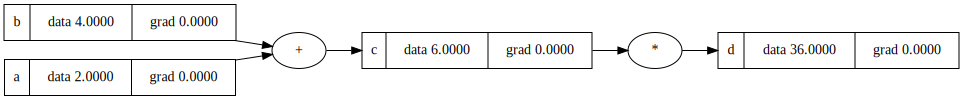

In [35]:
draw_dot(d)

In [41]:
d.backward()

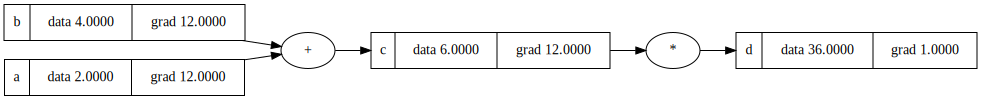

In [42]:
draw_dot(d)

In [23]:


def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [6]:
o.backward()

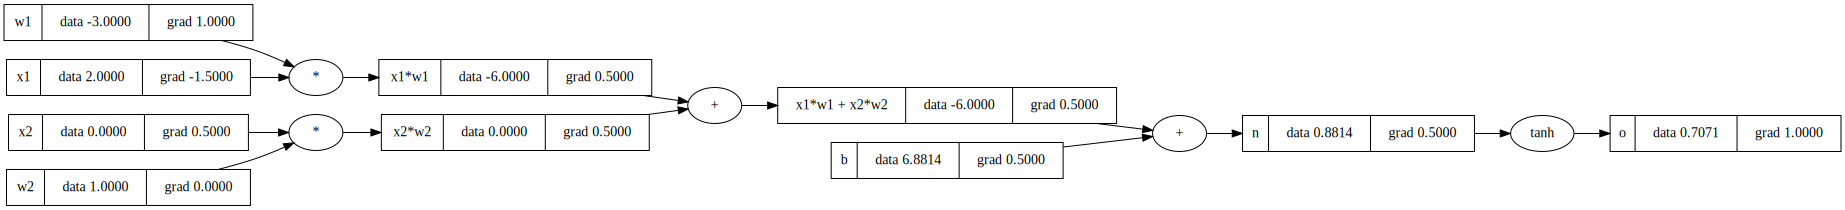

In [7]:
draw_dot(o)

## We are now deconstructing tanh into its composition. Our results should match the above graph because of mathematical equivalence

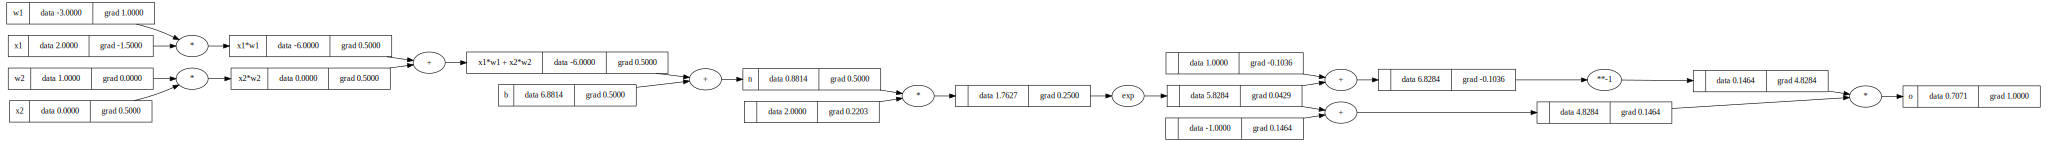

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Pytorch implementation of the above code

In [9]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:
o.data.item()

0.7071066904050358

In [12]:
import random

In [26]:
# Coding a neuron

class Neuron:
    
    def __init__(self,num_param):
        self.w=[Value(random.uniform(-1,1)) for i in range(num_param)]
        self.b=Value(random.uniform(-1,1))
        
    def __call__(self,input):
        #print((w1*x1 for w1,x1 in zip(self.w,input)))
        act=sum((w1*x1 for w1,x1 in zip(self.w,input)),self.b)
        #print(act)
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for i in range(nout)]
        
    def __call__(self,input):
        outs=[n(input) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
    
class MLP:
    def __init__(self,nin,layers):
        sn=[nin]+layers
        self.layers=[Layer(sn[i],sn[i+1]) for i in range(len(layers))]
        
    def __call__(self,input):
        for l in self.layers:
            input=l(input)
        return input

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
k=[2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(k)

Value(data=0.5239927364194561)

In [28]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [29]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 6.399175463740254
1 3.3202884642893618
2 1.0880156804589924
3 0.6450101050758477
4 0.1565627178481546
5 0.1246639766126314
6 0.10362637377354852
7 0.08862153260693648
8 0.07736393350655646
9 0.06860349532125143
10 0.061593103135301384
11 0.055857302801938666
12 0.05107868929892861
13 0.04703714120289476
14 0.04357516263199619
15 0.040577081711464597
16 0.03795603264903119
17 0.035645518059135205
18 0.03359377371729717
19 0.031759906095221585


In [31]:
ypred

[Value(data=0.9183428844513566),
 Value(data=-0.9350066359816612),
 Value(data=-0.8886933012551096),
 Value(data=0.90792012693541)]